# Lab 2. Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

## Data handling

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
with open("sonnets.txt", "r") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text.

Now variable `text` is a list of strings. Join all the strings into one.

In [9]:
# Join all the strings into one
# Put result into variable text.

text = "".join(text)
assert len(text) == 100225, "Are you sure you have concatenated all the strings?"

### Data loading: "Евгений Онегин"


In [6]:
with open("onegin.txt", "r") as iofile:
    text = iofile.readlines()

text = np.array([x.replace("\t\t", "") for x in text])

In opposite to the in-class practice, this time we want to predict complex text.

Now variable `text` is a list of strings. Join all the strings into one.

In [7]:
# Join all the strings into one
# Put result into variable text
text = "".join(text)
len(text)

141888

Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(set(text))
len(tokens)

127

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = {idx: token for token, idx in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {token: idx for token, idx in enumerate(tokens)}

In [8]:
# Convert text to indices
text_indices = np.array([token_to_idx[char] for char in text])

We have 127 tokens, so it's better to calculate the embedding (maybe a size of 50)

In [9]:
def data_loader(text_indices, seq_length, batch_size):
    # Calculate the number of complete batches per epoch
    num_batches = (len(text_indices) - seq_length) // batch_size

    # Shuffle the indices at the beginning of each epoch
    start_indices = np.random.permutation(len(text_indices) - seq_length)

    for batch_num in trange(num_batches):
        batch_start_indices = start_indices[
            batch_num * batch_size : (batch_num + 1) * batch_size
        ]

        batch_inputs = np.zeros((batch_size, seq_length), dtype=np.int32)

        for i, start_idx in enumerate(batch_start_indices):
            batch_inputs[i] = text_indices[start_idx : start_idx + seq_length]

        yield batch_inputs

    # Handle any remaining data that wasn't covered by the above loop
    remainder = len(text_indices) - seq_length - num_batches * batch_size
    if remainder > 0:
        batch_start_indices = start_indices[-remainder:]

        # If remainder < batch_size, create smaller batch
        remainder_batch_size = min(batch_size, remainder)
        batch_inputs = np.zeros((remainder_batch_size, seq_length), dtype=np.int32)

        for i, start_idx in enumerate(batch_start_indices):
            batch_inputs[i] = text_indices[start_idx : start_idx + seq_length]

        yield batch_inputs


## Vanilla RNN

In [22]:
model_params = {
    "n_tokens": len(tokens),
    "n_embedding": 32,
    "n_hidden": 64,
    "length_of_input": 32,
}

In [23]:
class VanillaRNN(nn.Module):
    def __init__(
        self,
        num_tokens=model_params["n_tokens"],
        embedding_size=model_params["n_embedding"],
        rnn_num_units=model_params["n_hidden"],
    ):
        super().__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(rnn_num_units + embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)

        x_and_h = torch.cat([h_prev, x_emb], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [25]:
vanilla_rnn = VanillaRNN().to(device)

In [103]:
def rnn_loop(rnn, batch):
    """
    batch: batch_size x num_tokens
    """
    hid_state = rnn.initial_state(batch.size()[0])
    logits = []

    for x in batch.transpose(0, 1):
        hid_state, logits_next = rnn(x, hid_state.to(device))
        logits.append(logits_next)

    return torch.stack(logits, dim=1)

### Testing the batching function

In [104]:
generator = data_loader(text_indices, model_params["length_of_input"], 128)

In [105]:
inputs = next(generator)
inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
logit_seq = rnn_loop(vanilla_rnn, inputs)

  0%|          | 0/1108 [00:00<?, ?it/s]

In [106]:
loss_func = nn.CrossEntropyLoss()
loss = loss_func(
    logit_seq[:, :-1].reshape((-1, model_params["n_tokens"])), inputs[:, 1:].reshape(-1)
)

In [107]:
loss.backward()

In [108]:
for w in vanilla_rnn.parameters():
    assert (
        w.grad is not None and torch.max(torch.abs(w.grad)).data.cpu().numpy() != 0
    ), (
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method."
        % (w.size(),)
    )

### Scripts for saving/loading models

In [10]:
def save_checkpoint(model, optimizer, epoch, loss_history, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss_history": loss_history,
    }
    torch.save(checkpoint, path)

In [17]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss_history = checkpoint["loss_history"]
    return epoch, loss_history

### Training

In [114]:
model = VanillaRNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [115]:
training_params = {"n_epochs": 20, "batch_size": 256}

In [116]:
# Initialize variables to track the best model
best_loss = float("inf")
best_epoch = -1

In [117]:
loss_history = []

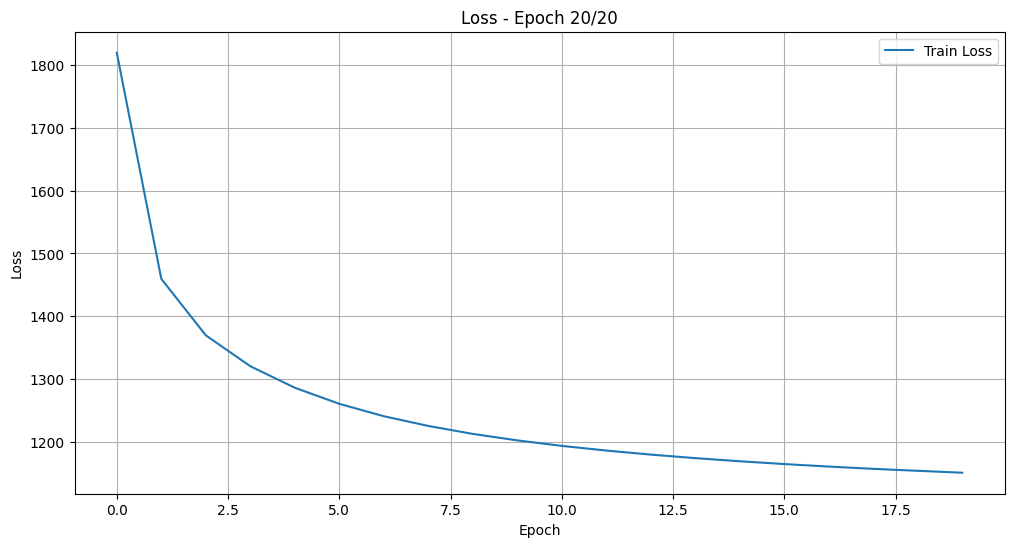

Epoch 20/20: Train Loss = 1150.5878


In [118]:
for epoch in range(training_params["n_epochs"]):
    batch_generator = data_loader(
        text_indices, model_params["length_of_input"], training_params["batch_size"]
    )
    batch_loss = []

    progress_bar = tqdm(
        batch_generator,
        desc=f"Epoch {epoch + 1}/{training_params['n_epochs']} - Training",
        leave=False,
    )

    for inputs in batch_generator:
        inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
        logit_seq = rnn_loop(model, inputs)
        loss = loss_func(
            logit_seq[:, :-1].reshape((-1, model_params["n_tokens"])),
            inputs[:, 1:].reshape(-1),
        )
        batch_loss.append(loss.detach().cpu().numpy())

        loss.backward()
        opt.step()
        opt.zero_grad()

    loss_history.append(np.sum(batch_loss))

    if loss_history[-1] < best_loss:
        best_loss = loss_history[-1]
        best_epoch = epoch + 1

        save_checkpoint(
            model, opt, best_epoch, loss_history, "lab02_part03_rnn_onegin.pth"
        )

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Loss - Epoch {epoch + 1}/{training_params["n_epochs"]}')
    plt.legend()
    plt.grid(True)

    plt.show()

    print(
        f"Epoch {epoch + 1}/{training_params['n_epochs']}: "
        f"Train Loss = {loss_history[-1]:.4f}"
    )

### Text generation

In [135]:
def generate_sample(model, seed_phrase="Евгений", max_length=100, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    """

    x_sequence = [token_to_idx[token] for token in seed_phrase.lower()]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = model.initial_state(batch_size=1).to(device)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = model(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [137]:
# Text generation with different temperature values here
temps = [0.1, 0.2, 0.5, 0.7, 0.9, 1.0, 2.0]
seed_phrase = "Евгений"
text_length = 250
for t in temps:
    title = f" Temperature {t} "
    print(f"{title:=^100}")
    print(generate_sample(model, seed_phrase, text_length, t))

========================================= Temperature 0.1 ==========================================
евгений,
И в ней не в странить поровал странить в своей постали постали в ней не в своей сердце странный своей сердце странить в старинный странить в странить в половенный своей постали половой подовенный своей сердце странить в своей сердце странить
========================================= Temperature 0.2 ==========================================
евгений своей приводит он в половенный друг не на своей души половой сон не володной вздомной не волненье странит он полова странить сердце не в том все дело в странет был поставы старинной не в своей не в ней не в советельный страни,
И в ней верной 
========================================= Temperature 0.5 ==========================================
евгений
И мужена роком личает потом лицом полова в старали,
В оченье.
Она следний сегин и молодит подалона прустила
Сон невод лет полка своей молечный доло всех, полком, как и той был по посланик

## LSTM

Let's use LSTM instead of vanilla RNN and compare the results.

In [16]:
class CustomLSTM(nn.Module):
    def __init__(self, n_tokens, embedding_size, hidden_size, num_layers):
        super().__init__()

        self.embedding = nn.Embedding(n_tokens, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.hidden_to_logits = nn.Linear(hidden_size, n_tokens)

    def forward(self, x, h_prev=None, c_prev=None):
        x_emb = self.embedding(x)

        if h_prev is None:
            output, (h_cur, c_cur) = self.lstm(x_emb)
        else:
            output, (h_cur, c_cur) = self.lstm(x_emb, (h_prev, c_prev))

        logits = self.hidden_to_logits(output)

        return logits, h_cur, c_cur

In [17]:
lstm_model_params = {
    "n_layers": 3,
    "hidden_size": 128,
    "embedding_size": 64,
    "n_tokens": len(tokens),
    "seq_length": 128,
}

#### Simple test

In [141]:
lstm_model = CustomLSTM(
    n_tokens=lstm_model_params["n_tokens"],
    embedding_size=lstm_model_params["embedding_size"],
    hidden_size=lstm_model_params["hidden_size"],
    num_layers=lstm_model_params["n_layers"],
).to(device)

In [142]:
generator = data_loader(text_indices, lstm_model_params["seq_length"], batch_size=128)

In [143]:
batch = next(generator)
batch = torch.tensor(batch, dtype=torch.int64).to(device)
batch.size()

  0%|          | 0/1107 [00:00<?, ?it/s]

torch.Size([128, 128])

In [144]:
output, hidden_state, cell_state = lstm_model(batch)

In [145]:
output.size(), hidden_state.size(), cell_state.size()

(torch.Size([128, 128, 127]),
 torch.Size([3, 128, 128]),
 torch.Size([3, 128, 128]))

In [146]:
loss_func = nn.CrossEntropyLoss()
loss = loss_func(
    output[:, :-1].reshape((-1, lstm_model_params["n_tokens"])),
    batch[:, 1:].reshape(-1),
)

In [147]:
loss.backward()

In [148]:
for w in lstm_model.parameters():
    assert (
        w.grad is not None and torch.max(torch.abs(w.grad)).data.cpu().numpy() != 0
    ), (
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method."
        % (w.size(),)
    )

#### Training

In [14]:
lstm_model = CustomLSTM(
    n_tokens=lstm_model_params["n_tokens"],
    embedding_size=lstm_model_params["embedding_size"],
    hidden_size=lstm_model_params["hidden_size"],
    num_layers=lstm_model_params["n_layers"],
).to(device)
opt = torch.optim.Adam(lstm_model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [159]:
training_params = {"n_epochs": 500, "batch_size": 256}

In [160]:
loss_history = []

In [161]:
# Initialize variables to track the best model
best_loss = float("inf")
best_epoch = -1

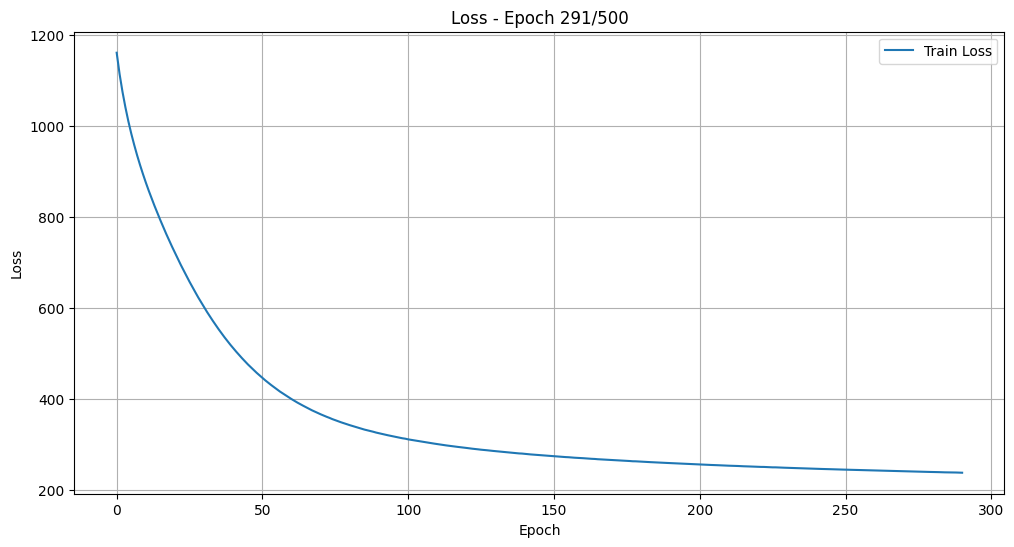

In [ ]:
for epoch in range(training_params["n_epochs"]):
    batch_generator = data_loader(
        text_indices, model_params["length_of_input"], training_params["batch_size"]
    )
    batch_loss = []

    progress_bar = tqdm(
        batch_generator,
        desc=f"Epoch {epoch + 1}/{training_params['n_epochs']} - Training",
        leave=False,
    )

    for inputs in batch_generator:
        inputs = torch.tensor(inputs, dtype=torch.int64).to(device)
        logit_seq, _, _ = lstm_model(inputs)
        loss = loss_func(
            logit_seq[:, :-1].reshape((-1, lstm_model_params["n_tokens"])),
            inputs[:, 1:].reshape(-1),
        )
        batch_loss.append(loss.detach().cpu().numpy())

        loss.backward()
        opt.step()
        opt.zero_grad()

    loss_history.append(np.sum(batch_loss))

    if loss_history[-1] < best_loss:
        best_loss = loss_history[-1]
        best_epoch = epoch + 1

        save_checkpoint(
            lstm_model, opt, best_epoch, loss_history, "lab02_part03_lstm_onegin.pth"
        )

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Loss - Epoch {epoch + 1}/{training_params["n_epochs"]}')
    plt.legend()
    plt.grid(True)

    plt.show()

    print(
        f"Epoch {epoch + 1}/{training_params['n_epochs']}: "
        f"Train Loss = {loss_history[-1]:.4f}"
    )

#### Text generation

In [24]:
def generate_sample(model, seed_phrase="Евгений", max_length=100, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    """

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    if seed_phrase:
        output, hidden_state, cell_state = model(x_sequence[:, :-1])
        hidden_state = hidden_state[:, 0]
        cell_state = cell_state[:, 0]
    else:
        hidden_state, cell_state = None, None

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        output, hidden_state, cell_state = model(
            x_sequence[:, -1], hidden_state, cell_state
        )

        p_next = F.softmax(output / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

In [25]:
# Text generation with different temperature values here
temps = [0.1, 0.2, 0.5, 0.7, 0.9, 1.0, 2.0]
seed_phrase = "Евгений"
text_length = 250
for t in temps:
    title = f" Temperature {t} "
    print(f"{title:=^100}")
    print(generate_sample(lstm_model, seed_phrase, text_length, t))

========================================= Temperature 0.1 ==========================================
Евгений,
Как описал себя пиит.
Всё было тихо; лишь ночные
Перекликались часовые;
Да дрожек отдаленный стук
С Мильонной раздавался вдруг;
Лишь лодка, веслами махая,
Плыла по дремлющей реке:
И нас пленяли вдалеке
Рожок и песня удалая…
Но слаще, средь н
========================================= Temperature 0.2 ==========================================
Евгений,
Как описал себя пиит.
Всё было тихо; лишь ночные
Перекликались часовые;
Да дрожек отдаленный стук
С Мильонной раздавался вдруг;
Лишь лодка, веслами махая,
Плыла по дремлющей реке:
И нас пленяли вдалеке
Рожок и песня удалая…
Но слаще, средь н
========================================= Temperature 0.5 ==========================================
Евгений,
Как описал себя пиит.
Всё было тихо; лишь ночные
Перекликались часовые;
Да дрожек отдаленный стук
С Мильонной раздавался вдруг;
Лишь лодка, веслами махая,
Плыла по дремлющей реке:
И нас 

## References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>